# Dynamic batching EDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_from_disk

from gLM.data_utils import DynamicBatchSampler, DynamicDataCollator

/home/ubuntu/filesystem1/HuggingfaceTransformer/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = "../../../data/train_representative"
ds_train = load_from_disk(data_dir)

In [3]:
lengths = [sample["length"] for sample in ds_train]

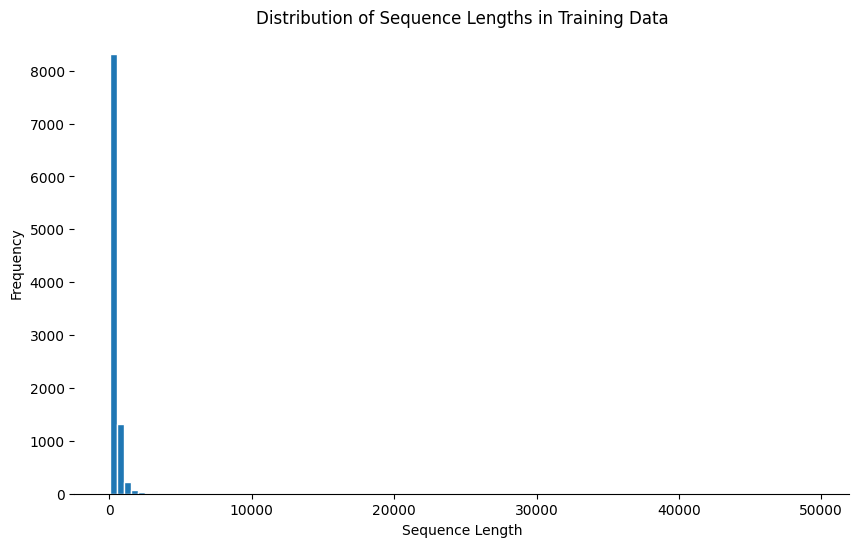

In [4]:
plt.figure(figsize=(10, 6), dpi=100)

plt.hist(lengths, bins=100, edgecolor="white")

for spine in ['top', 'right', 'left']:
    plt.gca().spines[spine].set_visible(False)

plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Sequence Lengths in Training Data")
plt.show()



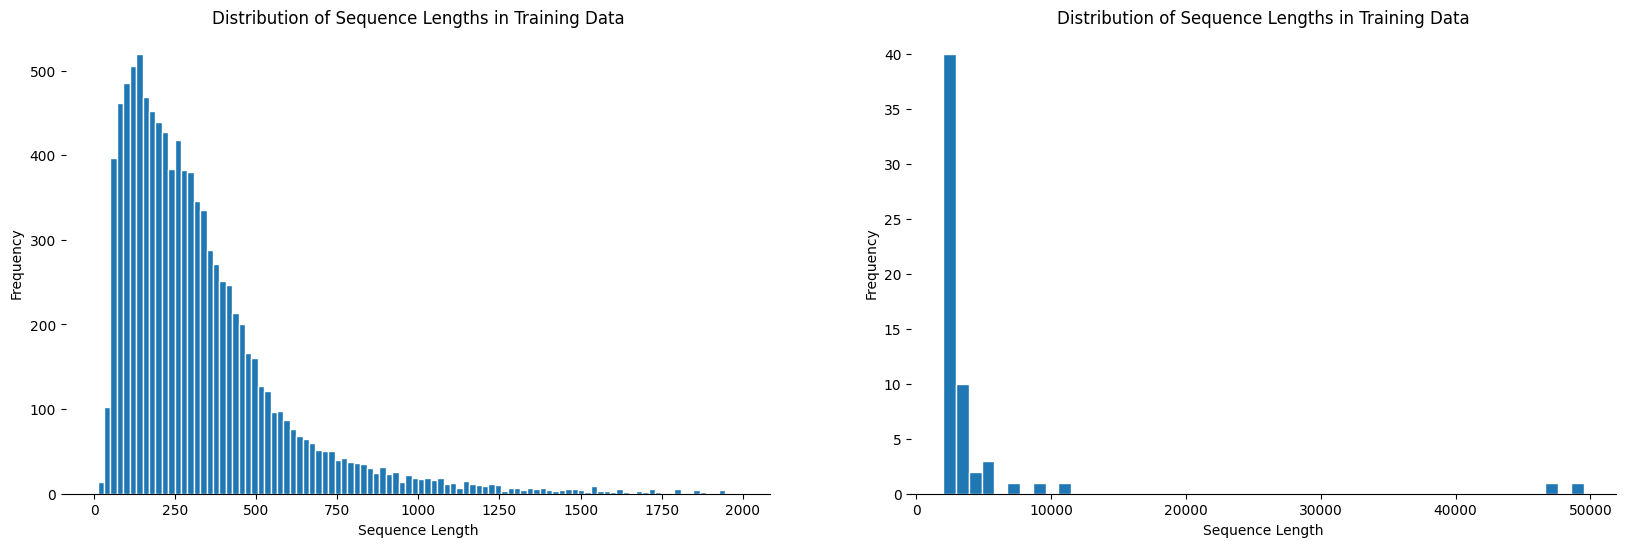

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=2,figsize=(20, 6), dpi=100)

axs[0].hist([l for l in lengths if l < 2000], bins=100, edgecolor="white")
axs[1].hist([l for l in lengths if l >= 2000], bins=50, edgecolor="white")

for ax in axs:
    for spine in ['top', 'right', 'left']:
        ax.spines[spine].set_visible(False)

    ax.set_xlabel("Sequence Length")
    ax.set_ylabel("Frequency")
    ax.set_title("Distribution of Sequence Lengths in Training Data")
plt.show()

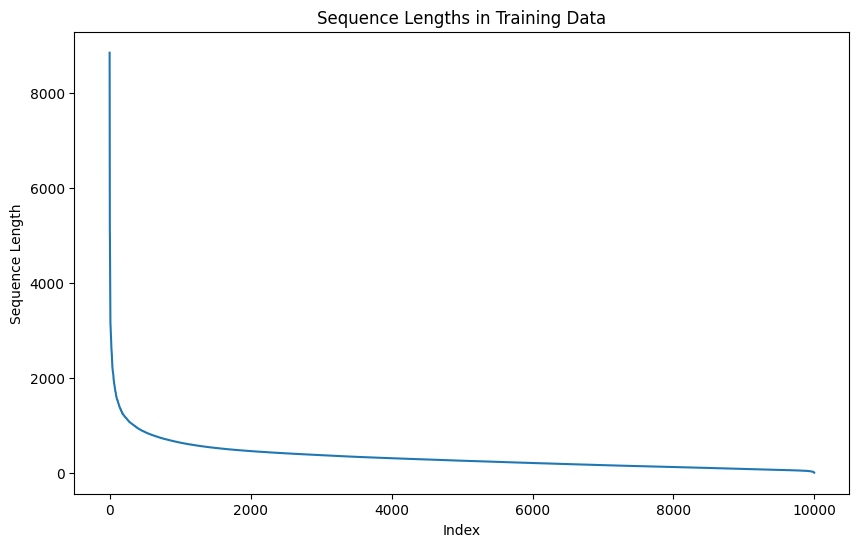

In [6]:
plt.figure(figsize=(10, 6), dpi=100)

plt.plot(list(reversed(sorted(lengths)))[3:], "-")

plt.xlabel("Index")
plt.ylabel("Sequence Length")
plt.title("Sequence Lengths in Training Data")
plt.show()


In [7]:
# Create dynamic batch sampler
sampler = DynamicBatchSampler(
    dataset=ds_train,
    max_tokens_per_batch=50_000,
    shuffle=False,  # Don't shuffle for analysis
    drop_last=False,
)

In [9]:
for i, batch_indices in enumerate(sampler):
    print(batch_indices)
    if i > 10:
        break

[5861]
[2182]
[6022, 1805, 189, 1898]
[2557, 6382, 4698, 4428, 4741, 878, 7333, 1633, 2434]
[5803, 1338, 751, 8218, 7032, 4637, 1345, 4285, 5193, 4356, 6800, 7926, 9489, 843, 840, 9099]
[4035, 6133, 9564, 8931, 5142, 1515, 1668, 5999, 7790, 1545, 2928, 7682, 5838, 3705, 1606, 202, 9759, 9868, 3712]
[9198, 6819, 8879, 2303, 8963, 838, 8035, 990, 7293, 5546, 5648, 6034, 3897, 2576, 9456, 683, 1841, 4735, 1389, 3384, 6811, 2112, 397]
[8167, 6029, 2105, 7884, 5971, 5446, 6189, 972, 5650, 1830, 7764, 7689, 2121, 7861, 1829, 9084, 5956, 5718, 1956, 5616, 9378, 6582, 2787, 5261, 4642, 5471, 2852]
[535, 6226, 7913, 4398, 5028, 9764, 4879, 4080, 5363, 7480, 8186, 360, 2527, 6493, 6449, 669, 9614, 4502, 5685, 567, 8685, 9554, 7525, 8812, 6773, 7982, 1913, 5734, 6470, 6814, 8721]
[117, 5345, 4347, 6799, 3536, 6745, 2171, 2084, 1789, 3428, 4980, 2232, 9318, 9716, 4763, 3654, 1802, 9985, 8606, 1305, 4257, 226, 8681, 5638, 2375, 1772, 1474, 395, 4720, 2841, 6426, 2679, 5210, 291]
[656, 9833, 6174, 7

## Trying it myself

In [ ]:
ds_train_sorted = ds_train.sort(column_names=["length"], reverse=True)

In [37]:
grouped_batches = []
curr_idx = 0
max_tokens_per_batch = 50_000
while curr_idx < len(ds_train_sorted):
    first_sample = ds_train_sorted[curr_idx]
    curr_length = first_sample["length"]
    num_samples_in_batch = int(max_tokens_per_batch // curr_length)
    grouped_batches.append(ds_train_sorted[curr_idx:curr_idx+num_samples_in_batch])
    curr_idx += num_samples_in_batch

Text(0.5, 1.0, 'Batch Size vs Max Sequence Length')

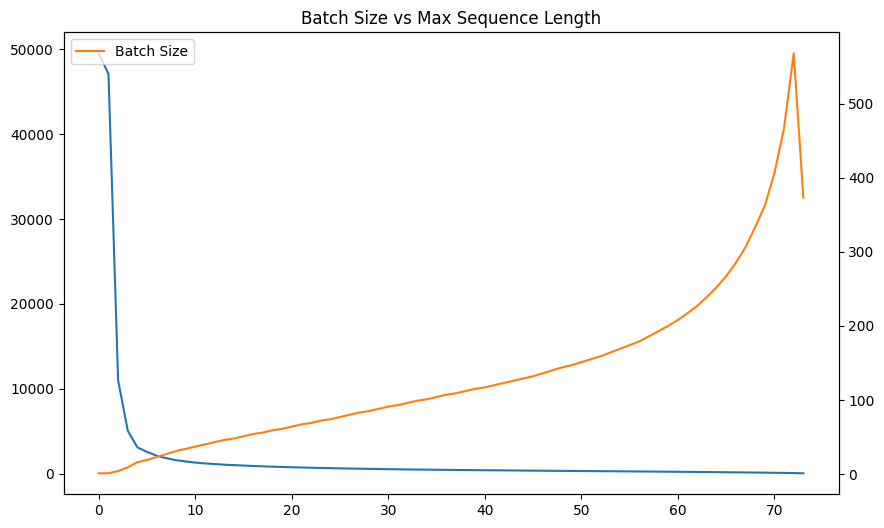

In [52]:
max_lengths = [max(batch["length"]) for batch in grouped_batches]
batch_sizes = [len(batch["length"]) for batch in grouped_batches]

plt.figure(figsize=(10, 6), dpi=100)

plt.plot(max_lengths, "-", label="Max Sequence Length"  )
plt.gca().twinx().plot(batch_sizes, "-", label="Batch Size", c="tab:orange")
plt.legend()

plt.title("Batch Size vs Max Sequence Length")

Text(0.5, 1.0, 'Batch Size vs Max Sequence Length')

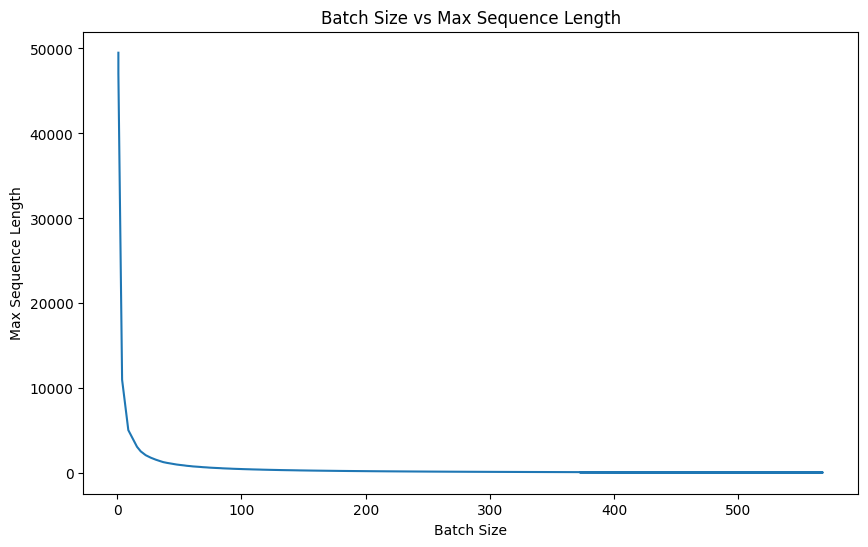

In [53]:
max_lengths = [max(batch["length"]) for batch in grouped_batches]
batch_sizes = [len(batch["length"]) for batch in grouped_batches]

plt.figure(figsize=(10, 6), dpi=100)

plt.plot(batch_sizes, max_lengths, "-")
plt.xlabel("Batch Size")
plt.ylabel("Max Sequence Length")

plt.title("Batch Size vs Max Sequence Length")

Text(0.5, 1.0, 'Batch Size vs Max Sequence Length')

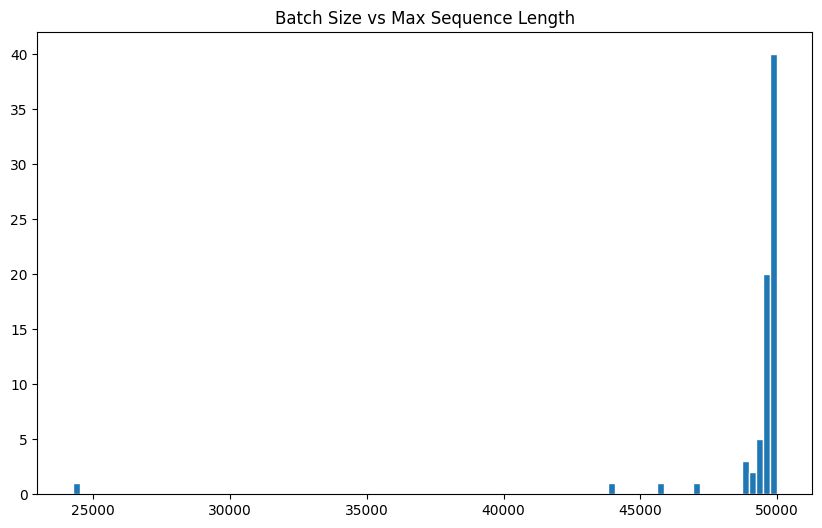

In [54]:
plt.figure(figsize=(10, 6), dpi=100)

padded_tokens_per_batch = [batch_max_length * batch_size for batch_max_length, batch_size in zip(max_lengths, batch_sizes)]
plt.hist(padded_tokens_per_batch, bins=100, edgecolor="white")

plt.title("Batch Size vs Max Sequence Length")